<a href="https://colab.research.google.com/github/sckgn/FinalYearProject_ML/blob/main/AdaTest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn

In [2]:
asd_2018_df = pd.read_csv('dataset_2018.csv')

In [3]:
asd_2018_df.rename(columns={'Class/ASD Traits ':'ASD_Traits'}, inplace=True)

# **Default parameters**

##**Female dataset**

In [115]:
female_df = asd_2018_df[asd_2018_df['Sex']=='f']

In [116]:
female_df = female_df.drop(['Case_No', 'Qchat-10-Score','Who completed the test','Ethnicity','Sex'], axis=1)

In [117]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler

encoder = OrdinalEncoder()
y_encoder = LabelEncoder()
scaler = MinMaxScaler()

age = ['Age_Mons']
# char_vals = ['Sex','Jaundice','Family_mem_with_ASD']
char_vals = ['Jaundice','Family_mem_with_ASD']
target = ['ASD_Traits']

In [118]:
from sklearn.model_selection import train_test_split

X = female_df.drop("ASD_Traits", axis=1)
y = female_df["ASD_Traits"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [119]:
print(np.unique(y_train))

['No' 'Yes']


In [120]:
X.columns

Index(['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'Age_Mons',
       'Jaundice', 'Family_mem_with_ASD'],
      dtype='object')

In [121]:
X_train[age] = scaler.fit_transform(X_train[age].values.reshape(-1,1))
X_test[age] = scaler.transform(X_test[age].values.reshape(-1,1))
for c in char_vals:
  X_train[c] = encoder.fit_transform(X_train[c].values.reshape(-1,1))
  X_test[c] = encoder.transform(X_test[c].values.reshape(-1,1))
y_train = y_encoder.fit_transform(y_train.values.ravel())
y_test = y_encoder.transform(y_test.values.ravel())

In [122]:
print(y_test)

[1 1 1 1 0 1 1 1 0 1 0 1 0 1 0 1 1 0 1 0 0 1 0 1 1 1 1 0 0 0 1 1 0 1 1 1 0
 0 1 1 0 0 1 0 1 1 1 0 0 1 0 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 1 0 1 0 1 0 1
 1 1 1 0 1 1 1 0 0 1 0 1 0 0 1 0 1 1 0 1 1 0]


In [123]:
from sklearn.ensemble import AdaBoostClassifier

ada = AdaBoostClassifier(n_estimators=100, random_state=42)
ada.fit(X_train, y_train)

AdaBoostClassifier(n_estimators=100, random_state=42)

In [124]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

In [125]:
metrics ={'accuracy': make_scorer(accuracy_score),
          'precision': make_scorer(precision_score),
          'recall' : make_scorer(recall_score),
          'f1_score' : make_scorer(f1_score)}

In [126]:
def cross_validation_results(model, predictors, target, metrics):
  results = cross_validate(model, predictors, target, scoring = metrics, return_train_score=False, cv=10)

  print("Mean Test Precision: ", results['test_precision'].mean())
  print("Mean Test Recall: ", results['test_recall'].mean())
  print("Mean Test F1: ", results['test_f1_score'].mean())
  print("Accuracy: ", results['test_accuracy'].mean())

In [127]:
cross_validation_results(ada, X_train, y_train, metrics)

Mean Test Precision:  0.9803571428571429
Mean Test Recall:  0.9851648351648352
Mean Test F1:  0.981925925925926
Accuracy:  0.9776679841897234


In [16]:
from sklearn.metrics import ConfusionMatrixDisplay

def evaluate_on_test(model, predictors, target):
  predictions = model.predict(predictors)
  print("Accuracy: ", accuracy_score(target, predictions))
  print("Precision: ", precision_score(target, predictions, average='binary', pos_label=1))
  print("Recall: ", recall_score(target, predictions))
  print("F1: ", f1_score(target, predictions))
  ConfusionMatrixDisplay.from_estimator(model, predictors, target)

Accuracy:  0.96875
Precision:  0.9508196721311475
Recall:  1.0
F1:  0.9747899159663865


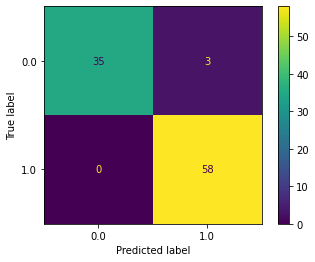

In [17]:
evaluate_on_test(ada, X_test, y_test)

In [18]:
def show_incorrectly_classified(predictors, predictions, target):
  for row_index, (input, prediction, label) in enumerate(zip(predictors.values, predictions, target)):
    if prediction != label:
        print('Row', row_index, 'has been classified as', prediction, 'and should be', label, "\nInput:",input)

In [19]:
show_incorrectly_classified(X_test, ada.predict(X_test), y_test)

Row 4 has been classified as 1.0 and should be [0.] 
Input: [1.         0.         0.         0.         1.         0.
 0.         0.         0.         1.         0.70833333 0.
 0.         0.        ]
Row 32 has been classified as 1.0 and should be [0.] 
Input: [1.         0.         0.         1.         0.         1.
 0.         0.         0.         0.         0.70833333 0.
 0.         0.        ]
Row 40 has been classified as 1.0 and should be [0.] 
Input: [0.         0.         0.         1.         0.         0.
 1.         0.         0.         1.         0.91666667 0.
 0.         1.        ]


In [20]:
ada.learning_rate

1.0

In [21]:
ada.n_estimators

100

#**GridSearchCV**

##**Female**

In [22]:
grid_female = female_df = asd_2018_df[asd_2018_df['Sex']=='f']

In [23]:
grid_female = grid_female.drop(['Case_No', 'Qchat-10-Score','Who completed the test','Ethnicity'], axis=1)

In [24]:
from sklearn.pipeline import Pipeline

X_grid = grid_female.drop("ASD_Traits", axis=1)
y_grid = grid_female["ASD_Traits"]

X_grid_train, X_grid_test, y_grid_train, y_grid_test = train_test_split(X_grid, y_grid, test_size=0.3, random_state=42, stratify=y)


In [25]:
y_grid_train

750    Yes
285     No
901    Yes
902    Yes
228    Yes
      ... 
53     Yes
835     No
170     No
362    Yes
39      No
Name: ASD_Traits, Length: 223, dtype: object

In [26]:
from sklearn.compose import ColumnTransformer

cat_vals = ['Sex','Jaundice','Family_mem_with_ASD']

preprocess = ColumnTransformer(
    transformers=[
        ('scaling',MinMaxScaler(),['Age_Mons']),
        ('encoding',OrdinalEncoder(),cat_vals)
    ]
)
pipeline = Pipeline(steps=[('preprocess', preprocess),
                             ('classifier', AdaBoostClassifier(random_state=42))])

target_encoder = LabelEncoder()

In [27]:
y_grid_train_prepared = target_encoder.fit_transform(y_grid_train.values.reshape(-1,1))

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [28]:
param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__learning_rate': [0.01, 0.1, 1.0],
}

In [29]:
scorers = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, pos_label='Yes'),
    'recall': make_scorer(recall_score,pos_label='Yes'),
    'f1_score': make_scorer(f1_score,pos_label='Yes')
}

In [30]:
from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(pipeline, param_grid=param_grid,cv=5, scoring=scorers, refit='accuracy')

In [31]:
grid_search

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('scaling',
                                                                         MinMaxScaler(),
                                                                         ['Age_Mons']),
                                                                        ('encoding',
                                                                         OrdinalEncoder(),
                                                                         ['Sex',
                                                                          'Jaundice',
                                                                          'Family_mem_with_ASD'])])),
                                       ('classifier',
                                        AdaBoostClassifier(random_state=42))]),
             param_grid={'classifier__learning_rate': [0.01, 0.1, 1.0],
                         'classifier__n_estimators': [50, 100, 200]},
             refit='accuracy',
             scoring={'accuracy': make_scorer(accuracy_score),
                      'f1_score': make_scorer(f1_score, pos_label=Yes),
                      'precision': make_scorer(precision_score, pos_label=Yes),
                      'recall': make_scorer(recall_score, pos_label=Yes)})

In [32]:
grid_search.fit(X_grid_train, y_grid_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('scaling',
                                                                         MinMaxScaler(),
                                                                         ['Age_Mons']),
                                                                        ('encoding',
                                                                         OrdinalEncoder(),
                                                                         ['Sex',
                                                                          'Jaundice',
                                                                          'Family_mem_with_ASD'])])),
                                       ('classifier',
                                        AdaBoostClassifier(random_state=42))]),
             param_grid={'classifier__learning_rate': [0.01, 0.1, 1.0],
                         'classifier__n_estimators': [50, 100, 200]},
             refit='accuracy',
             scoring={'accuracy': make_scorer(accuracy_score),
                      'f1_score': make_scorer(f1_score, pos_label=Yes),
                      'precision': make_scorer(precision_score, pos_label=Yes),
                      'recall': make_scorer(recall_score, pos_label=Yes)})

In [33]:
y_grid_train

750    Yes
285     No
901    Yes
902    Yes
228    Yes
      ... 
53     Yes
835     No
170     No
362    Yes
39      No
Name: ASD_Traits, Length: 223, dtype: object

In [34]:
accuracy = grid_search.cv_results_['mean_test_accuracy']
precision = grid_search.cv_results_['mean_test_precision']
recall = grid_search.cv_results_['mean_test_recall']
f1 = grid_search.cv_results_['mean_test_f1_score']

print("Best parameters: {}".format(grid_search.best_params_))
print("Best score: {:.2f}".format(grid_search.best_score_))
print("Accuracy: ", accuracy.mean())
print("Precision: ", precision.mean())
print("Recall: ", recall.mean())
print("F1 Score: ", f1.mean())


Best parameters: {'classifier__learning_rate': 1.0, 'classifier__n_estimators': 200}
Best score: 0.71
Accuracy:  0.6940179573512908
Precision:  0.6971402164473061
Recall:  0.8925631981187537
F1 Score:  0.7804019527637908


In [35]:
def show_grid_cv_results(model):
  accuracy = model.cv_results_['mean_test_accuracy']
  precision = model.cv_results_['mean_test_precision']
  recall = model.cv_results_['mean_test_recall']
  f1 = model.cv_results_['mean_test_f1_score']

  print("Best parameters: {}".format(model.best_params_))
  print("Best score: {:.2f}".format(model.best_score_))
  print("Accuracy: ", accuracy.mean())
  print("Precision: ", precision.mean())
  print("Recall: ", recall.mean())
  print("F1 Score: ", f1.mean())

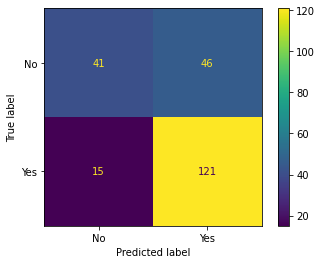

In [36]:
ConfusionMatrixDisplay.from_estimator(grid_search.best_estimator_, X_grid_train, y_grid_train)

In [37]:
y_grid_pred = grid_search.predict(X_grid_test)

In [38]:
y_grid_test

241     Yes
1017    Yes
185     Yes
910     Yes
18       No
       ... 
587     Yes
701      No
527     Yes
438     Yes
768      No
Name: ASD_Traits, Length: 96, dtype: object

In [39]:
def evaluate_classes(model, predictors, target):
  predictions = model.predict(predictors)
  print("Accuracy: ", accuracy_score(target, predictions))
  print("Precision[YES]: ", precision_score(target, predictions, average='binary', pos_label='Yes'))
  print("Recall[YES]: ", recall_score(target, predictions,average='binary', pos_label='Yes'))
  print("F1[YES]: ", f1_score(target, predictions,average='binary', pos_label='Yes'))

  ConfusionMatrixDisplay.from_estimator(model, predictors, target)

Accuracy:  0.625
Precision[YES]:  0.6774193548387096
Recall[YES]:  0.7241379310344828
F1[YES]:  0.7


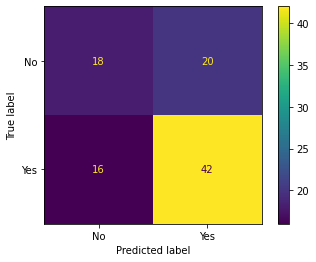

In [40]:
evaluate_classes(grid_search, X_grid_test, y_grid_test)

##**Pre-processed without a pipeline**

In [128]:
param_grid_new = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1.0],
}

In [137]:
scorers_new = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='binary', pos_label=1),
    'recall': make_scorer(recall_score,average='binary',pos_label=1),
    'f1_score': make_scorer(f1_score,average='binary',pos_label=1)
}

In [138]:
ada_grid = GridSearchCV(ada,param_grid=param_grid_new,cv=5, scoring=scorers_new, refit='accuracy' )

In [139]:
ada_grid

GridSearchCV(cv=5,
             estimator=AdaBoostClassifier(n_estimators=100, random_state=42),
             param_grid={'learning_rate': [0.01, 0.1, 1.0],
                         'n_estimators': [50, 100, 200]},
             refit='accuracy',
             scoring={'accuracy': make_scorer(accuracy_score),
                      'f1_score': make_scorer(f1_score, average=binary, pos_label=1),
                      'precision': make_scorer(precision_score, average=binary, pos_label=1),
                      'recall': make_scorer(recall_score, average=binary, pos_label=1)})

In [140]:
ada_grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=AdaBoostClassifier(n_estimators=100, random_state=42),
             param_grid={'learning_rate': [0.01, 0.1, 1.0],
                         'n_estimators': [50, 100, 200]},
             refit='accuracy',
             scoring={'accuracy': make_scorer(accuracy_score),
                      'f1_score': make_scorer(f1_score, average=binary, pos_label=1),
                      'precision': make_scorer(precision_score, average=binary, pos_label=1),
                      'recall': make_scorer(recall_score, average=binary, pos_label=1)})

In [141]:
show_grid_cv_results(ada_grid)

Best parameters: {'learning_rate': 1.0, 'n_estimators': 100}
Best score: 0.99
Accuracy:  0.9545342312008979
Precision:  0.9585513298138439
Recall:  0.970487948265726
F1 Score:  0.9635099165451706


In [145]:
ada_best = ada_grid.best_estimator_
ada_best

AdaBoostClassifier(n_estimators=100, random_state=42)

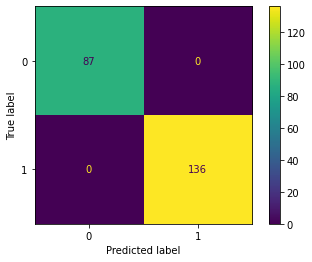

In [148]:
ConfusionMatrixDisplay.from_estimator(ada_best, X_train, y_train)

In [146]:
def final_evaluation(model, predictors, target):
  predictions = model.predict(predictors)
  print("Accuracy: ", accuracy_score(target, predictions))
  print("Precision[YES]: ", precision_score(target, predictions, average='binary', pos_label=1))
  print("Recall[YES]: ", recall_score(target, predictions,average='binary', pos_label=1))
  print("F1[YES]: ", f1_score(target, predictions,average='binary', pos_label=1))

  ConfusionMatrixDisplay.from_estimator(model, predictors, target)

Accuracy:  0.96875
Precision[YES]:  0.9508196721311475
Recall[YES]:  1.0
F1[YES]:  0.9747899159663865


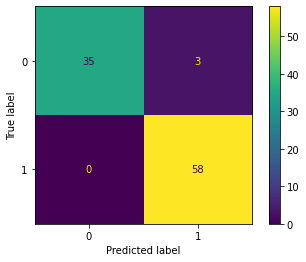

In [147]:
final_evaluation(ada_best, X_test, y_test)

##**Mixed**

In [41]:
grid_mixed = asd_2018_df.drop(['Case_No', 'Qchat-10-Score','Who completed the test','Ethnicity'], axis=1)

In [42]:
X_mixed_grid = grid_mixed.drop("ASD_Traits", axis=1)
y_mixed_grid = grid_mixed["ASD_Traits"]

X_mixed_grid_train, X_mixed_grid_test, y_mixed_grid_train, y_mixed_grid_test = train_test_split(X_mixed_grid, y_mixed_grid, test_size=0.3, random_state=42, stratify=y_mixed_grid)

In [43]:
grid_search_mixed = GridSearchCV(pipeline, param_grid=param_grid,cv=5, scoring=scorers, refit='accuracy')

In [44]:
grid_search_mixed.fit(X_mixed_grid_train, y_mixed_grid_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('scaling',
                                                                         MinMaxScaler(),
                                                                         ['Age_Mons']),
                                                                        ('encoding',
                                                                         OrdinalEncoder(),
                                                                         ['Sex',
                                                                          'Jaundice',
                                                                          'Family_mem_with_ASD'])])),
                                       ('classifier',
                                        AdaBoostClassifier(random_state=42))]),
             param_grid={'classifier__learning_rate': [0.01, 0.1, 1.0],
                         'classifier__n_estimators': [50, 100, 200]},
             refit='accuracy',
             scoring={'accuracy': make_scorer(accuracy_score),
                      'f1_score': make_scorer(f1_score, pos_label=Yes),
                      'precision': make_scorer(precision_score, pos_label=Yes),
                      'recall': make_scorer(recall_score, pos_label=Yes)})

In [45]:
show_grid_cv_results(grid_search_mixed)

Best parameters: {'classifier__learning_rate': 0.1, 'classifier__n_estimators': 200}
Best score: 0.70
Accuracy:  0.6913587056444199
Precision:  0.7002896925984258
Recall:  0.967719320951703
F1 Score:  0.8123526374851081


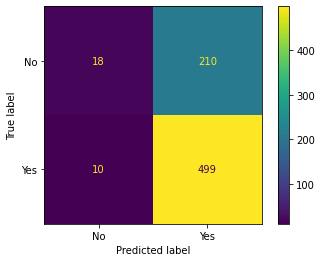

In [46]:
ConfusionMatrixDisplay.from_estimator(grid_search_mixed.best_estimator_, X_mixed_grid_train, y_mixed_grid_train)

In [47]:
y_mixed_grid_pred = grid_search_mixed.predict(X_mixed_grid_test)

Accuracy:  0.7003154574132492
Precision[YES]:  0.7
Recall[YES]:  0.9908675799086758
F1[YES]:  0.8204158790170133


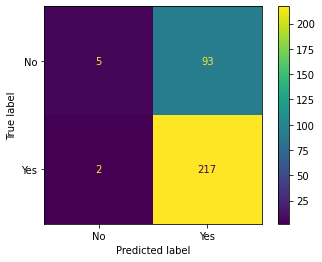

In [48]:
evaluate_classes(grid_search_mixed, X_mixed_grid_test, y_mixed_grid_test)

In [49]:
features = list(grid_mixed)

In [50]:
best_model = grid_search_mixed.best_estimator_
best_model

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('scaling', MinMaxScaler(),
                                                  ['Age_Mons']),
                                                 ('encoding', OrdinalEncoder(),
                                                  ['Sex', 'Jaundice',
                                                   'Family_mem_with_ASD'])])),
                ('classifier',
                 AdaBoostClassifier(learning_rate=0.1, n_estimators=200,
                                    random_state=42))])

In [51]:
classifier_best = best_model.named_steps['classifier']

In [52]:
classifier_best.base_estimator

'deprecated'

In [53]:
importances_mixed = grid_search_mixed.best_estimator_.named_steps['classifier'].base_estimator.feature_importances_

mixed_sorted = sorted(zip(importances_mixed, features), reverse=True)

AttributeError: ignored